# Imports

In [1]:
! pip install tensorflow --upgrade -qq
! pip install keras_cv --upgrade -qq

     |████████████████████████████████| 578.0 MB 14 kB/s 
     |████████████████████████████████| 1.7 MB 52.3 MB/s 
     |████████████████████████████████| 438 kB 67.3 MB/s 
     |████████████████████████████████| 5.9 MB 30.4 MB/s 
     |████████████████████████████████| 289 kB 5.1 MB/s 


In [2]:
# Import the necessary packages
import keras_cv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from typing import Optional

import matplotlib.pyplot as plt

In [3]:
# Checking the versions of the packages
print(f"TensorFlow version: {tf.__version__}")
print(f"TensorFlow version: {keras_cv.__version__}")

TensorFlow version: 2.10.0
TensorFlow version: 0.3.1


# Get the image

In [4]:
image_name = "dog.png"
image_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg"

In [25]:
def load_image(image_path: str):
	image = tf.io.read_file(image_path)
	image = tf.image.decode_image(image, channels=3)
	return image

# Get the image from the url and load the image as a `tf.tensor`
image_path = keras.utils.get_file(
	image_name,
	image_url,
)
image = load_image(image_path)

# Adding batch dimension to the image
image = image[tf.newaxis, ...]

In [26]:
# Plot the image
def display_image(image: tf.Tensor, gray: bool = False):
  if gray:
    plt.imshow(image[..., 0], cmap="gray")
  else:
    plt.imshow(image)
  plt.axis("off")
  plt.show()

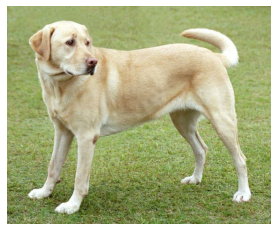

In [28]:
# Display the original image
display_image(image[0])

# Augmentation Layers

[Reference](https://github.com/facebookresearch/msn/blob/4388dc1eadbe3042b85d3296d41b9b207656e043/src/data_manager.py#L85-L104)

## RandomResizedCrop

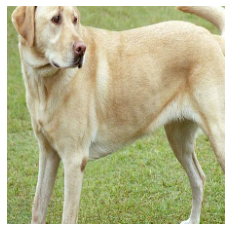

In [29]:
# Configurations
rand_size = (224, 224)
focal_size = (96, 96)
rand_crop_scale=(0.3, 1.0)
focal_crop_scale=(0.05, 0.3)

rand_resized_crop_layer = keras_cv.layers.RandomResizedCrop(
    target_size=rand_size,
    crop_area_factor=rand_crop_scale,
    aspect_ratio_factor=(0.75, 1.3), # defaults from torch
)

# Randomly resize and crop the image and display it
rand_resized_crop_image = rand_resized_crop_layer(image)
display_image(rand_resized_crop_image[0].numpy().astype("int32"))

## Random Horizontal Flip

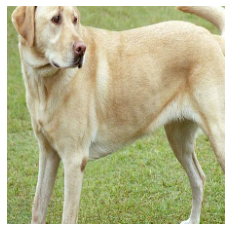

In [30]:
rand_flip_layer = keras_cv.layers.RandomFlip(mode="horizontal")

# Randomly flip the image horizontally and display it
rand_flip_image = rand_flip_layer(rand_resized_crop_image)
display_image(rand_flip_image[0].numpy().astype("int32"))

## Color Distortion

- `transforms.ColorJitter` is similar to `keras_cv.layers.RandomColorJitter` 

In [31]:
class Identity(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def call(self, inputs):
        return inputs

def random_apply(layer: layers.Layer, probability_map: Optional[float] = 0.5):
    if tf.random.uniform([]) < probability_map:
        return layer
    else:
        return Identity()

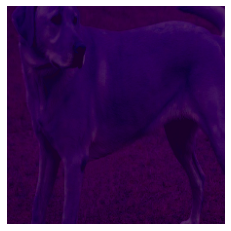

In [32]:
# Configurations
s = 1.0

color_jitter_layer = keras_cv.layers.RandomColorJitter(
    value_range=(0, 255),
    brightness_factor=0.8*s,
    contrast_factor=0.8*s,
    saturation_factor=0.8*s,
    hue_factor=0.8*s,
)
rnd_color_jitter_layer = random_apply(
    layer=color_jitter_layer,
    probability_map=0.8
)        


# Randomly color jitter the image and display it
rnd_color_jitter_image = rnd_color_jitter_layer(rand_flip_image)
display_image(rnd_color_jitter_image[0].numpy().astype("int32"))

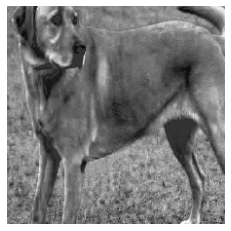

In [34]:
gray_scale_layer = keras_cv.layers.Grayscale()
rnd_gray_layer = random_apply(
    layer=gray_scale_layer,
    probability_map=0.2,
)

# Randomly gray scale the image and display it
rnd_gray_image = rnd_gray_layer(rnd_color_jitter_image)
display_image(rnd_gray_image[0].numpy().astype("int32"), gray=True)

# Gaussian Blur

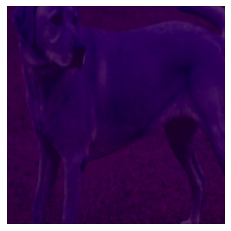

In [35]:
rand_gaussian_blur_layer = keras_cv.layers.RandomGaussianBlur(
    kernel_size=(3, 3),
    factor=(0.5, 0.5),
)

# Apply a gaussian blur to the image and display it
rand_gaussian_blur_image = rand_gaussian_blur_layer(rnd_gray_image)
display_image(rand_gaussian_blur_image[0].numpy().astype("int32"))

# Combining all the Transformations together

In [ ]:
augmentation_layer = keras.Sequential([
    rand_resized_crop_layer,
    rand_flip_layer,
    rnd_color_jitter_layer,
    rnd_gray_layer,
    rand_gaussian_blur_layer,
])

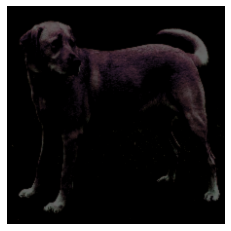

In [41]:
augmentaiton_image = augmentation_layer(image)
display_image(augmentaiton_image[0].numpy().astype("int32"))